/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


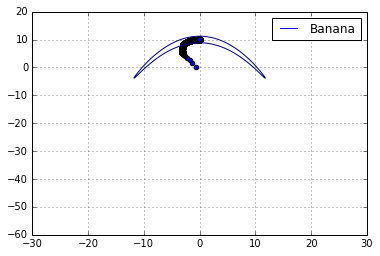

In [1]:
%matplotlib inline
import sys
import os
sys.path.insert(0, os.path.join(os.path.abspath("."), "..", "..", ".."))

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pysgmcmc.samplers.svgd import SVGDSampler

from pysgmcmc.diagnostics.objective_functions import (
    banana_log_likelihood,
)

from collections import namedtuple

ObjectiveFunction = namedtuple(
    "ObjectiveFunction", ["function", "dimensionality"]
)

objective_functions = (
    ObjectiveFunction(
        function=banana_log_likelihood, dimensionality=2
    ),
)


def cost_function(log_likelihood_function):
    def wrapped(*args, **kwargs):
        return -log_likelihood_function(*args, **kwargs)
    wrapped.__name__ = log_likelihood_function.__name__
    return wrapped

#  Banana Contour {{{ #
def banana_plot():
    #x = np.arange(-30, 30, 0.05)
    #y = np.arange(-60, 20, 0.05)
    x = np.arange(-25, 25, 0.05)
    y = np.arange(-50, 20, 0.05)
    xx, yy = np.meshgrid(x, y, sparse=True)
    densities = np.asarray([np.exp(banana_log_likelihood((x, y))) for x in xx for y in yy])
    f, ax = plt.subplots(1)
    xdata = [1, 4, 8]
    ydata = [10, 20, 30]
    ax.contour(x, y, densities, 1, label="Banana")
    ax.plot([], [], label="Banana")
    ax.legend()
    ax.grid()
    #ax.set_ylim(ymin=-10, ymax=40)
    #ax.set_xlim(xmin=-6, xmax=7)
    ax.set_ylim(ymin=-60, ymax=20)
    ax.set_xlim(xmin=-30, xmax=30)
    
#  }}} Banana Contour #


plot_functions = {
    "banana_log_likelihood": banana_plot,
}


def extract_samples(sampler, n_samples=1000, keep_every=10):
    from itertools import islice
    n_iterations = n_samples * keep_every
    return np.asarray(
        [np.mean(sample, axis=0) for sample, _ in
         islice(sampler, 0, n_iterations, keep_every)]
    )

def plot_samples(sampler, n_samples=5000, keep_every=10):
    samples = extract_samples(
        sampler, n_samples=n_samples, keep_every=keep_every
    )
    plot_functions[sampler.cost_fun.__name__]()
    
    first_sample = samples[0]
    try:
        sample_dimensionality, = first_sample.shape
    except ValueError:
        plt.scatter(samples, np.exp([-sampler.cost_fun(sample) for sample in samples]))
    else:
        plt.scatter(*[samples[:, i] for i in range(sample_dimensionality)])

        
n_particles = 2

# tf.reset_default_graph()

graph = tf.Graph()

with tf.Session(graph=graph) as session:

    
    params = [tf.get_variable("x", shape=(1,), initializer=tf.random_normal_initializer()),
          tf.get_variable("y", shape=(1,), initializer=tf.random_normal_initializer())
    ]

    def duplicate_params(params, i, session):
        duplicate = []
        for var in params:
            name = var.name.split(":")[0] + "_" + str(i)
            dup_var = tf.get_variable(name, initializer=var.initializer._inputs[1])
            # session.run(tf.variables_initializer([dup_var]))
            duplicate.append(dup_var)
        return duplicate
    """particles = [
        duplicate_params(params, session=session, i=i)
        for i in range(n_particles)
    ]
    for particle in particles:
        for var in particle:
            session.run(tf.variables_initializer([var]))
    p = session.run(particles)
    v = tf.reduce_mean(particles, axis=1)
    print(session.run(v))"""
for function, dimensionality in objective_functions:
    tf.reset_default_graph()
    graph = tf.Graph()
    
    with tf.Session(graph=graph) as session:
        params = tf.get_variable("particles", (10, dimensionality), initializer=tf.random_normal_initializer())
        sampler = SVGDSampler(
            particles=params,
            cost_fun=cost_function(function),
            session=session,
            dtype=tf.float32
        )
        plot_samples(sampler, n_samples=5000)
        plt.show()